In [23]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels
import statsmodels.sandbox.stats.multicomp
import pandas as pd
import datetime
from statsmodels.stats.weightstats import ztest

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from sklearn.utils import shuffle
import hashlib
from base64 import b64encode
import collections
from joblib import Parallel, delayed
from scipy.stats import norm

In [7]:
interactions = pd.read_csv('data_kion/interactions_df.csv')
users = pd.read_csv('data_kion/users.csv')
items = pd.read_csv('data_kion/items.csv')

!!!  Все считаем на 1000 итерациях


### Дизайн теста бутстреп
1. Из interactions взять данные за 2 последние недели (2021-08-09 по 2021-08-22)

2. Посчитайте на этих данных корректность на бутстрепе и сравните ее с результатами за 1 неделю (посчитано на семинаре) (2 балла)

3. На двух неделях посчитайте мощность. Для этого нужно в одну из групп докинуть эффект. Докиньте эффект в 1%, 3% и 5% и сравните полученную мощность (3 балла за расчет + 2 балла за подроброе объяснение)

4. Посчитайте MDE, который можно зафиксировать на 2х неделях. В качестве alpha и beta подставьте ваши вычисленные ошибки 1 и 2 рода. Учитывайте что у нас формула для MDE работает для t-test или z-test (3 балла)


### Дизайн продолжение

1. Посчитать аналогичный дизайн для:
  - бутстреп + логарифмированная метрика длительности просмотров (4 балла)
  - манна-уитни + метрика длительности просмотров (4 балла)
  - манна-уитни + логарифмированная метрика длительности просмотров (4 балла)
  - t-test + метрика длительности просмотров (4 балла)
  - t-test + логарифмированная метрика длительности просмотров (4 балла)
2. Подробно описать выводы для каждой пары, какие варианты точно не подходят и почему. Объяснить зачем мы логарифмируем метрику и что нам это дает. Аргументированно выбрать 1 пару (метрика + критерий) которым вы будете оценивать АБ тест и какой эффект мы сможем отловить в нашем тесте. (5 баллов)


### A/B тест
1) Представим что у нас прошел тест, используем те же самые данные за 2 недели

2) Занулите для всех пользователей total_dur, у которых total_dur < 500. Их НЕ УБИРАЕМ, а просто обрабатываем эти значения, принимая за нулевые, но пользователей также учитываем в эксперименте (2 балла)

3) Разбейте их самостоятельно на две равные группы, используйте функцию groups_splitter и соль = 'kiontestmodel20210805' (1 балла)

4) Оказалось, что модель в группе В показала себя лучше, чем в группе А на 2.5%, причем эффект распространился неравномерно и преимущественно на 10% самых смотрящих пользователей, докиньте такой эффект самостоятельно. Нужно метрику total_dur увеличить на 2.5% для 10% пользователей с самым продолжительным смотрением. (2 балла)

5) Посчитайте результат такого теста и сделайте выводы (10 баллов)





In [5]:
interactions.head(5)

,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0


In [16]:
users.head()

,user_id,age,income,sex,kids_flg
0,973171,age_25_34,income_60_90,М,1
1,962099,age_18_24,income_20_40,М,0
2,1047345,age_45_54,income_40_60,Ж,0
3,721985,age_45_54,income_20_40,Ж,0
4,704055,age_35_44,income_60_90,Ж,0


In [15]:
users.groupby('age', as_index=False).count()[['age', 'user_id']]

,age,user_id
0,age_18_24,127672
1,age_25_34,233926
2,age_35_44,207043
3,age_45_54,135925
4,age_55_64,75265
5,age_65_inf,46271


In [17]:
items.head(5)

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords
0,10711,film,Поговори с ней,Hable con ella,2002.0,"драмы, зарубежные, детективы, мелодрамы",Испания,NaN,16.0,NaN,Педро Альмодовар,"Адольфо Фернандес, Ана Фернандес, Дарио Гранди...",Мелодрама легендарного Педро Альмодовара «Пого...,"Поговори, ней, 2002, Испания, друзья, любовь, ..."
1,2508,film,Голые перцы,Search Party,2014.0,"зарубежные, приключения, комедии",США,NaN,16.0,NaN,Скот Армстронг,"Адам Палли, Брайан Хаски, Дж.Б. Смув, Джейсон ...",Уморительная современная комедия на популярную...,"Голые, перцы, 2014, США, друзья, свадьбы, прео..."
2,10716,film,Тактическая сила,Tactical Force,2011.0,"криминал, зарубежные, триллеры, боевики, комедии",Канада,NaN,16.0,NaN,Адам П. Калтраро,"Адриан Холмс, Даррен Шалави, Джерри Вассерман,...",Профессиональный рестлер Стив Остин («Все или ...,"Тактическая, сила, 2011, Канада, бандиты, ганг..."
3,7868,film,45 лет,45 Years,2015.0,"драмы, зарубежные, мелодрамы",Великобритания,NaN,16.0,NaN,Эндрю Хэй,"Александра Риддлстон-Барретт, Джеральдин Джейм...","Шарлотта Рэмплинг, Том Кортни, Джеральдин Джей...","45, лет, 2015, Великобритания, брак, жизнь, лю..."
4,16268,film,Все решает мгновение,NaN,1978.0,"драмы, спорт, советские, мелодрамы",СССР,NaN,12.0,Ленфильм,Виктор Садовский,"Александр Абдулов, Александр Демьяненко, Алекс...",Расчетливая чаровница из советского кинохита «...,"Все, решает, мгновение, 1978, СССР, сильные, ж..."


In [8]:
items.groupby('content_type', as_index=False).count()[['content_type', 'item_id']]

,content_type,item_id
0,film,12002
1,series,3961


In [10]:
# предобработка данных
interactions['last_watch_dt'] = pd.to_datetime(interactions['last_watch_dt']).map(lambda x: x.date())
interactions['user_id'] = interactions['user_id'].astype(str)

print(f"Уникальных юзеров в interactions: {interactions['user_id'].nunique():_}")
print(f"Уникальных айтемов в interactions: {interactions['item_id'].nunique():_}")

Уникальных юзеров в interactions: 962_179
Уникальных айтемов в interactions: 15_706


In [11]:
max_date = interactions['last_watch_dt'].max()
min_date = interactions['last_watch_dt'].min()
print(min_date, max_date)

2021-03-13 2021-08-22


In [12]:
interactions[interactions['last_watch_dt'] >= max_date - datetime.timedelta(days=14)]['user_id'].nunique()

279129

In [13]:
week = interactions[interactions['last_watch_dt'] >= max_date - datetime.timedelta(days=14)]
week = week.groupby('user_id', as_index=False).agg({'total_dur': sum})

/var/folders/s5/mqf_xzbd7d9g3vfp08fpm2bc0000gn/T/ipykernel_11052/3072904357.py:2: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  week = week.groupby('user_id', as_index=False).agg({'total_dur': sum})


In [14]:
week.head()

,user_id,total_dur
0,1,21172
1,1000,10744
2,1000000,33776
3,1000001,52
4,1000003,625


In [15]:
def salt_generator(salt=None):
    import os
    from base64 import b64encode
    salt = os.urandom(8)

    return b64encode(salt).decode('ascii')


def get_bootstrap_array(arr):
    return np.random.choice(arr, replace=True, size=len(arr))


def calc_bootstrap_mean(arr, size=1000):
    result = np.empty(size)
    for i in range(size):
        result[i] = np.mean(get_bootstrap_array(arr))
    return result

def get_p_value(dist):
    dist = np.array(dist)
    x = (dist > 0).mean()
    pvalue = min(x, 1 - x) * 2
    return pvalue

In [16]:
def groups_splitter(df, columns, user_salt=None):

    if user_salt == None:
        salt = salt_generator()
    else:
        salt = user_salt

    df['hash'] = ((df['user_id'].astype(str)) + '#' + salt).apply(lambda x: hashlib.sha256(x.encode('utf-8')).hexdigest())

    df['group'] = ((df['hash'].str.slice(start=-6).apply(int, base=16) % 2).map(lambda x: 'A' if x == 0 else 'B'))

    return df[columns].drop_duplicates()

2. Посчитайте на этих данных корректность на бутстрепе и сравните ее с результатами за 1 неделю (посчитано на семинаре) (2 балла)

In [25]:
correctness = []
values = []

for i in tqdm(range(1000)): # в дз используем 1000 итераций

    new_df = groups_splitter(week.copy(), columns=['user_id', 'total_dur', 'group'], user_salt=salt_generator()).drop_duplicates()


    vec_a = new_df[(new_df['group'] == 'A')]['total_dur']
    vec_b = new_df[(new_df['group'] == 'B')]['total_dur']

    #bootstrap
    sample_a_mean = calc_bootstrap_mean(vec_a, size=1000) # на бутстрэпе считаем средние для вектора
    sample_b_mean = calc_bootstrap_mean(vec_b, size=1000)
    values.append(sample_a_mean - sample_b_mean)

    left_side, right_side = np.percentile(sample_a_mean - sample_b_mean,
                                                  [100 * 0.05 / 2., 100 * (1 - 0.05 / 2.)]) # считаем 95% доверительный интервал для разницы средних

    correctness.append(not left_side <= 0 <= right_side)

    test_correctness = collections.Counter(correctness)

print(f'significance: {test_correctness[1]/(test_correctness[1] + test_correctness[0])*100}%')

100%|██████████| 1000/1000 [2:08:41<00:00,  7.72s/it] 

significance: 5.1%


### Корректность на 1 и 2 недели соответственно: 2.0%, 5.1%

3. На двух неделях посчитайте мощность. Для этого нужно в одну из групп докинуть эффект. Докиньте эффект в 1%, 3% и 5% и сравните полученную мощность (3 балла за расчет + 2 балла за подроброе объяснение)

In [17]:
power = []
values = []

for i in tqdm(range(1000)): # в дз используем 1000 итераций

    new_df = groups_splitter(week.copy(), columns=['user_id', 'total_dur', 'group'], user_salt=salt_generator()).drop_duplicates()


    vec_a = new_df[(new_df['group'] == 'A')]['total_dur']
    vec_b = new_df[(new_df['group'] == 'B')]['total_dur'] * (1+0.01) # докидаваем эффект в 1%

    #bootstrap
    sample_a_mean = calc_bootstrap_mean(vec_a, size=1000) # на бутстрэпе считаем средние для вектора
    sample_b_mean = calc_bootstrap_mean(vec_b, size=1000)
    values.append(sample_a_mean - sample_b_mean)

    left_side, right_side = np.percentile(sample_a_mean - sample_b_mean,
                                                  [100 * 0.05 / 2., 100 * (1 - 0.05 / 2.)]) # считаем 95% доверительный интервал для разницы средних

    power.append(not left_side <= 0 <= right_side)

    test_power = collections.Counter(power)

print(f'power: {test_power[1]/(test_power[1] + test_power[0])*100}%')

100%|██████████| 1000/1000 [1:16:49<00:00,  4.61s/it] 

power: 11.3%


In [19]:
def compute_iteration(i, week, groups_splitter, salt_generator, calc_bootstrap_mean, effect):
    new_df = groups_splitter(week.copy(), columns=['user_id', 'total_dur', 'group'], user_salt=salt_generator()).drop_duplicates()

    vec_a = new_df[new_df['group'] == 'A']['total_dur']
    vec_b = new_df[new_df['group'] == 'B']['total_dur'] * (1 + effect)

    sample_a_mean = calc_bootstrap_mean(vec_a, size=1000)
    sample_b_mean = calc_bootstrap_mean(vec_b, size=1000)

    diff = sample_a_mean - sample_b_mean
    left_side, right_side = np.percentile(diff, [100 * 0.05 / 2., 100 * (1 - 0.05 / 2.)])

    power = not (left_side <= 0 <= right_side)
    return power, diff

In [20]:
power = []
values = []

num_iterations = 1000
results = Parallel(n_jobs=-1)(delayed(compute_iteration)(
    i, week, groups_splitter, salt_generator, calc_bootstrap_mean, 0.03
) for i in tqdm(range(num_iterations)))

# Обработка результатов
power, values = zip(*results)
test_power = collections.Counter(power)

print(f'power: {test_power[True] / num_iterations * 100}%')

100%|██████████| 1000/1000 [16:52<00:00,  1.01s/it]


power: 63.7%


In [22]:
power = []
values = []

num_iterations = 1000
results = Parallel(n_jobs=-1)(delayed(compute_iteration)(
    i, week, groups_splitter, salt_generator, calc_bootstrap_mean, 0.05
) for i in tqdm(range(num_iterations)))

# Обработка результатов
power, values = zip(*results)
test_power = collections.Counter(power)

print(f'power: {test_power[True] / num_iterations * 100}%')

100%|██████████| 1000/1000 [17:48<00:00,  1.07s/it]


power: 97.0%


### Результаты за 2 недели

Мощность для 1% эффекта: 11.3 % - совсем плохо, редко обнаружим стат значимость\
Мощность для 3% эффекта: 63.7 % - получше, но все равно мало\
Мощность для 5% эффекта: 97 % - хорошо

Получается, что больший эффект мы с большей вероятностью и обнаружим

4. Посчитайте MDE, который можно зафиксировать на 2х неделях. В качестве alpha и beta подставьте ваши вычисленные ошибки 1 и 2 рода. Учитывайте что у нас формула для MDE работает для t-test или z-test (3 балла)

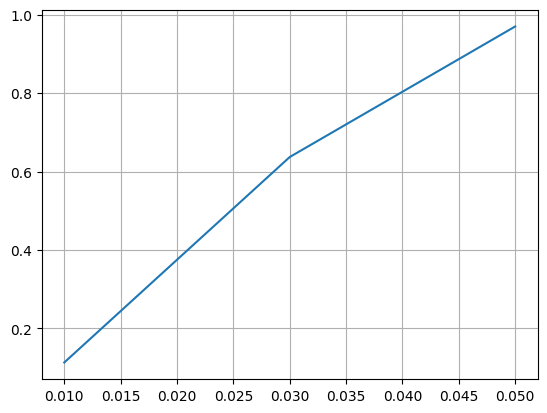

In [ ]:
effect_array = [0.01, 0.03, 0.05]
power_array = [0.113, 0.637, 0.97]

plt.plot(effect_array, power_array)
plt.ylabel("Power")
plt.xlabel("Effect")
plt.grid()
plt.show()

Воспользуемся линейно апроксимацией для поиска нужного MDE, при котором мощность $\beta = 0.8$

In [41]:
k = (power_array[2] - power_array[1]) / (effect_array[2] - effect_array[1])
b = power_array[2] - k * effect_array[2]

mde = (0.8 - b) / k
print(f"MDE = {mde * 100:5f}")

MDE = 3.978979


### Дизайн продолжение

1. Посчитать аналогичный дизайн для:
  - бутстреп + логарифмированная метрика длительности просмотров (4 балла)
  - манна-уитни + метрика длительности просмотров (4 балла)
  - манна-уитни + логарифмированная метрика длительности просмотров (4 балла)
  - t-test + метрика длительности просмотров (4 балла)
  - t-test + логарифмированная метрика длительности просмотров (4 балла)

In [47]:
def compute_iteration_log(i, week, groups_splitter, salt_generator, calc_bootstrap_mean, effect):
    new_df = groups_splitter(week.copy(), columns=['user_id', 'total_dur', 'group'], user_salt=salt_generator()).drop_duplicates()

    vec_a = np.log(new_df[new_df['group'] == 'A']['total_dur'])
    vec_b = np.log(new_df[new_df['group'] == 'B']['total_dur']) + np.log(1 + effect)

    sample_a_mean = calc_bootstrap_mean(vec_a, size=1000)
    sample_b_mean = calc_bootstrap_mean(vec_b, size=1000)

    diff = sample_a_mean - sample_b_mean
    left_side, right_side = np.percentile(diff, [100 * 0.05 / 2., 100 * (1 - 0.05 / 2.)])

    power = not (left_side <= 0 <= right_side)
    return power, diff

In [50]:
power = []
values = []

num_iterations = 1000
results = Parallel(n_jobs=-1)(delayed(compute_iteration_log)(
    i, week, groups_splitter, salt_generator, calc_bootstrap_mean, 0.01
) for i in tqdm(range(num_iterations)))

# Обработка результатов
power, values = zip(*results)
test_power = collections.Counter(power)

print(f'power for 1% effect: {test_power[True] / num_iterations * 100}%')

100%|██████████| 1000/1000 [18:07<00:00,  1.09s/it]


power for 1% effect: 20.4%


In [ ]:
power = []
values = []

num_iterations = 1000
results = Parallel(n_jobs=-1)(delayed(compute_iteration_log)(
    i, week, groups_splitter, salt_generator, calc_bootstrap_mean, 0.03
) for i in tqdm(range(num_iterations)))

# Обработка результатов
power, values = zip(*results)
test_power = collections.Counter(power)

print(f'power for 3% effect: {test_power[True] / num_iterations * 100}%')

In [ ]:
power = []
values = []

num_iterations = 1000
results = Parallel(n_jobs=-1)(delayed(compute_iteration_log)(
    i, week, groups_splitter, salt_generator, calc_bootstrap_mean, 0.05
) for i in tqdm(range(num_iterations)))

# Обработка результатов
power, values = zip(*results)
test_power = collections.Counter(power)

print(f'power for 5% effect: {test_power[True] / num_iterations * 100}%')